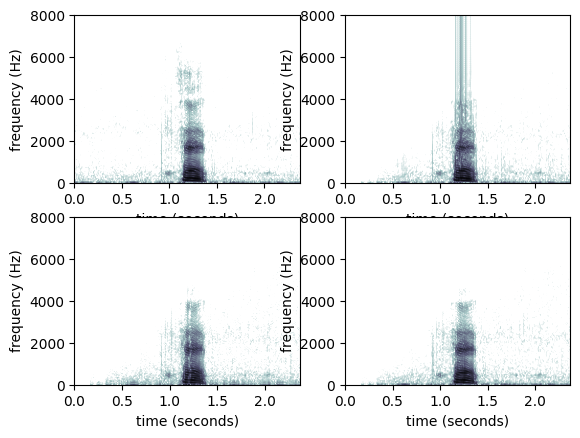

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import librosa
FIG_SIZE = (8,3)
cmap_plot = plt.cm.bone_r
minpercentile=80

def decibel_sq_safe(x, epsilon=1e-10):
    return 10*np.log10(np.maximum(np.real(x*np.conj(x)),epsilon))

def getFIRFFT(H, order, winname=None) :
    NFFT = (len(H)-1)*2
    # Mirror Image of 'Real Value' & Initialize the imaginary value to 0
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    
    h = np.fft.ifft(H, NFFT)
    
    order = min(NFFT-1, order)
    h = np.concatenate((h[(len(h)-order//2):], h[0:order//2+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real

def drawspectrogram2(x, Nf, Ns=None, winname='hamming', minpercentile=80, isdbscale=True, isdraw=True):
    # Short-time Fourier transform with half-overlap 
    # Nf: analysis size
    # Ns: shift size 
    # NFFT: FFT size, power of 2
    if Ns==None: Ns=Nf//2
    num_frames = (len(x)-Nf)//Ns+1  # 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
    hNo = NFFT//2+1
    X = np.zeros((hNo,num_frames))
    
    # generate window
    if winname=='rect' or winname=='rectangular':
        win = np.ones(Nf)
    else:   # hamming, hann, etc.
        win = librosa.filters.get_window(winname, Nf, fftbins=True)
        
    # STFT
    for i in range(num_frames):
        y = np.fft.fft(win*x[(i*Ns):(i*Ns+Nf)], n=NFFT)
        y = y[:hNo]
        if isdbscale: y = decibel_sq_safe(y)
        else: y = np.abs(y)
        X[:,i] = y

    if isdraw:
        # 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
        vmax = np.max(X[:])
        vmin = np.percentile(X[:], minpercentile)
        specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
        plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
        plt.xlabel('time (seconds)')
        plt.ylabel('frequency (Hz)')
    
    return X

def trpezoidal_win(len_shift, overlab = 0.3) :
    pre_win = np.linspace(0.0, 1.0, num = int(len_shift*overlab))
    mid_win = np.array([1.0]*(len_shift - 2*int(len_shift*overlab)))
    post_win = np.linspace(1.0, 0.0, num = int(len_shift*overlab))
    
    return np.concatenate((pre_win, mid_win, post_win), axis=-1)

def linear_cutoff1(x, Ns, order, overlap_rate = 0.3, winname='trapezodial') :
    N_win = int(Ns*(1.0+overlap_rate))
    num_frames = int((len(x)-N_win)//Ns +1)

    win = trpezoidal_win(N_win)
    X_hat = np.zeros(Ns*num_frames)

    for i in range(num_frames) :
        x_k = x[i*Ns: (i*Ns)+N_win]
        H = np.zeros(order, dtype=float)
        H[:int(order*i/num_frames)] = 1.0
        h = getFIRFFT(np.array(H), order, winname='hamming')
        x_f = signal.lfilter(h, [1.0], x_k)
        
        if winname == 'trapezodial':
            x_w = win* x_f
        else :
            x_w = x_f
        
        if(len(X_hat[i*Ns:]) < len(x_w)) :
            X_hat[i*Ns:] += x_w[:len(X_hat[i*Ns:])]
        else :
            X_hat[i*Ns:(i*Ns)+len(x_w)] += x_w
    return X_hat

def linear_cutoff2(x, Ns, order, overlap_rate = 0.3, winname='trapezodial') :
    pre_x = np.zeros(int(Ns*overlap_rate))
    pre_x_h = np.zeros(int(Ns*overlap_rate))
    N_win = Ns
    num_frames = int((len(x)-N_win)//Ns +1)

    win = trpezoidal_win(N_win+len(pre_x))
    X_hat = np.zeros(Ns*num_frames)

    for i in range(num_frames) :
        x_k = x[i*Ns: (i*Ns)+N_win]
        H = np.zeros(order, dtype=float)
        H[:int(order*i/num_frames)] = 1.0
        h = getFIRFFT(np.array(H), order, winname='hamming')
        x_k = np.concatenate((pre_x, x_k))
        x_f = signal.lfilter(h, [1.0], x_k)
        
        if winname == 'trapezodial':
            x_w = win* x_f
        else :
            x_w = x_f
        x_w[:len(pre_x_h)] += pre_x_h
        X_hat[i*Ns:(i*Ns)+N_win] = x_w[:Ns]
        pre_x_h = x_w[-len(pre_x_h):]
        pre_x = x_k[-len(pre_x):]
    return X_hat

filename = 'kdigits0-3'
order = 14
fb = 16000
Ts = 0.01
x, Fs = librosa.load(f'{filename}.wav', sr = fb)
Ns = int(Fs*Ts)
Nf = Ns *2

# 2,2,1 is raw spectrum
plt.subplot(2,2,1)
X =drawspectrogram2(x, Nf)

# 2,2,2 is only apply linear cutoff.(no win)
H = [1.0]*(order//2) + [0.0]*(order//2)
h = getFIRFFT(np.array(H), order, winname='hamming')
x2 = signal.lfilter(h, [1], x)
plt.subplot(2,2,2)
X_hat = linear_cutoff1(x, Ns, order, overlap_rate = 0.0, winname='None')
X =drawspectrogram2(X_hat, Nf)

# linear_cutoff1
#   using 13ms frame with 10ms shift and 3ms overlap
#   use win 'trapezodial'
X_hat = linear_cutoff1(x, Ns, order, overlap_rate = 0.0, winname='trapezodial')
plt.subplot(2,2,3)
X = drawspectrogram2(X_hat, Nf)
# linear_cutoff2
#   using 10ms frame with 10ms shift
#   using pre memory to make 13ms wav, and use win 'trapezodial'
X_hat2 = linear_cutoff2(x, Ns, order, overlap_rate = 0.3, winname='trapezodial')
plt.subplot(2,2,4)
X = drawspectrogram2(X_hat2, Nf)

